# Entrainement de modeles sur les images

## Transfer des des images depuis google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Les images sont stockées dans un zip sur google drive
!tar -zxvf drive/MyDrive/rakuten_images_in_classes.tar.gz

## Chargement des labels des classes de sortie (catégories de produits)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

# On charge les intitulés de catégorie
categories = pd.read_csv("drive/MyDrive/categories.csv", index_col=0, sep="\t")
display(categories.head(5))

# Nous avons placé les images dans des dossiers correspondants a chaque classe.
# Keras va charger les images ces dossiers. On trie les catégories dans le meme 
# ordre que les dossiers, pour plus tard faire le lien: 
#    numéro de dossier <-> label de catégorie.
categories_alphasort = categories.reset_index().astype(str).sort_values(by='prdtypecode')
def get_label(index):
  return categories_alphasort.iloc[int(index)].prdlabelcode

,prdlabelcode
prdtypecode,
10,Livre
40,Jeux-vidéos
50,Accessoires Jeux
60,Consoles de jeux
1140,figurines 1


## Entrainement d'un premier réseau convolutif simple de zéro

### Chargement des images

On charge les images dans deux dataset de type `tf.data`. Un dataset pour l'entrainement et un dataset pour la validation.

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE

def load_datasets(batch_size, input_size, use_augmentation=False):
  train_ds = image_dataset_from_directory(
    'rakuten/images',
     labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
  )

  validation_ds = image_dataset_from_directory(
    'rakuten/images',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
  )

  if use_augmentation:
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1, 0.1)
    ])
    train_ds = train_ds \
      .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  train_ds = train_ds \
    .prefetch(buffer_size=AUTOTUNE) \
    .repeat()
  validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

  return train_ds, validation_ds

Pour notre premier modèle nous choisissons de réduire la taille des images en les redimensionnant en 80x80, afin d'accélérer la phase d'apprentissage.

In [ ]:
BATCH_SIZE = 32
INPUT_SIZE = (80, 80)

train_ds, validation_ds = load_datasets(BATCH_SIZE, INPUT_SIZE)

Found 84916 files belonging to 27 classes.
Using 67933 files for training.
Found 84916 files belonging to 27 classes.
Using 16983 files for validation.


On affiche les premieres images de notre dataset d'entrainement.

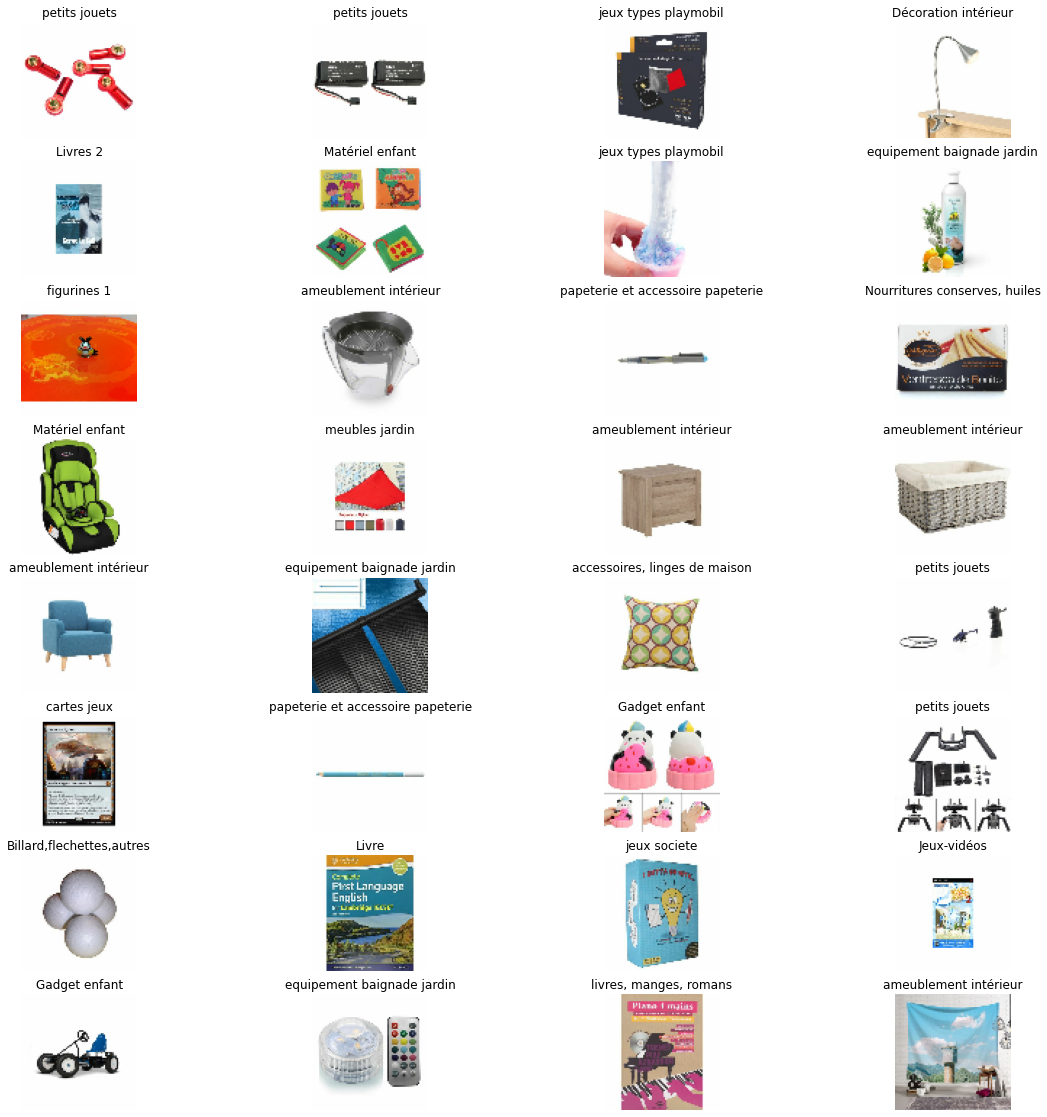

In [ ]:
import numpy as np

def display_first_images_from_dataset(ds, batch_size):
  plt.figure(figsize=(20, 20))
  for images, labels in ds.take(1):
    for i in range(0, batch_size):
      ax = plt.subplot(8, batch_size//8, i + 1)
      plt.imshow(images[i].numpy().astype("int32"))
      plt.title(get_label(int(labels[i])))
      plt.axis("off")

display_first_images_from_dataset(train_ds, BATCH_SIZE)

Notre premier réseau est inspiré du modele LeNet. Il s'agit d'un petit réseau convolutif que nous allons entrainer de zéro.
Nous choisissons de mettre deux couches de Convolution suivi de Maxpooling pour la partie extraction de feature.
Puis un Dropout pour régulariser, suivi de deux couches Denses et de la couche de sortie.

Nous utilisons `relu` pour la fonction d'activation car c'est la plus communément utilisés. Elle est rapide a calculer et se comporte bien.

Pour la couche de sortie `softmax` nous permet d'avoir une distribution de probabilité.

Le modele sera optimisé grace a `Adam`, et la fonction de perte est `sparse_categorical_crossentropy` car nos étiquettes de classes ne sont pas one-hot encodées (nous utilisons des entiers de 0 a 26 pour les 27 classes).

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

nb_of_classes = len(categories)
train_size = 67933
valid_size = 16983

inputs = Input(shape=(80,80,3), name='Input')
conv_1 = Conv2D(filters=60, kernel_size=(5,5), padding='valid', activation="relu", input_shape=(80,80,3))
pool_1 = MaxPooling2D(pool_size=(2,2))
conv_2 = Conv2D(filters=30, kernel_size=(3,3), padding='valid', activation="relu")
pool_2 = MaxPooling2D(pool_size=(2,2))
dropout = Dropout(rate = 0.2)
flatten = Flatten()
dense_1 = Dense(units = 128, activation = 'relu')
dense_2 = Dense(units = len(categories), activation = 'softmax')
outputs = dense_2(dense_1(flatten(dropout(pool_2(conv_2(pool_1(conv_1(inputs))))))))

model = Model(inputs = inputs, outputs = outputs)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 76, 76, 60)        4560      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 38, 38, 60)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 36, 36, 30)        16230     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 30)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 18, 18, 30)        0   

In [ ]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_simple'

On entraine notre modele sur 20 epoch maximum, et on utilise un callback early stopping défini sur la fonction de perte de validation.

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds, 
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback, earlystop]
)

Epoch 1/20
2122/2122 [==============================] - 199s 93ms/step - loss: 3.1745 - accuracy: 0.1532 - val_loss: 2.7685 - val_accuracy: 0.2144
Epoch 2/20
2122/2122 [==============================] - 208s 98ms/step - loss: 2.6432 - accuracy: 0.2493 - val_loss: 2.4655 - val_accuracy: 0.3019
Epoch 3/20
2122/2122 [==============================] - 197s 93ms/step - loss: 2.4233 - accuracy: 0.3100 - val_loss: 2.3798 - val_accuracy: 0.3295
Epoch 4/20
2122/2122 [==============================] - 199s 94ms/step - loss: 2.2751 - accuracy: 0.3500 - val_loss: 2.3258 - val_accuracy: 0.3449
Epoch 5/20
2122/2122 [==============================] - 208s 98ms/step - loss: 2.1713 - accuracy: 0.3777 - val_loss: 2.3126 - val_accuracy: 0.3540
Epoch 6/20
2122/2122 [==============================] - 199s 94ms/step - loss: 2.0630 - accuracy: 0.4038 - val_loss: 2.3182 - val_accuracy: 0.3573
Epoch 7/20
2122/2122 [==============================] - 240s 113ms/step - loss: 1.9708 - accuracy: 0.4305 - val_loss: 

Notre entrainement s'est arrété car la fonction de perte ne decroissait plus. On observe que la perte et l'accuracy sur l'ensemble d'entrainement continuaient a décroitre: notre modele entrait dans une phase de surapprentissage. Au final notre callback d'enregistrement de modele a choisi les poids de l'epoch numéro 5, pour lequel l'accuracy de validation est de 0.3540.

In [ ]:
history = history.history

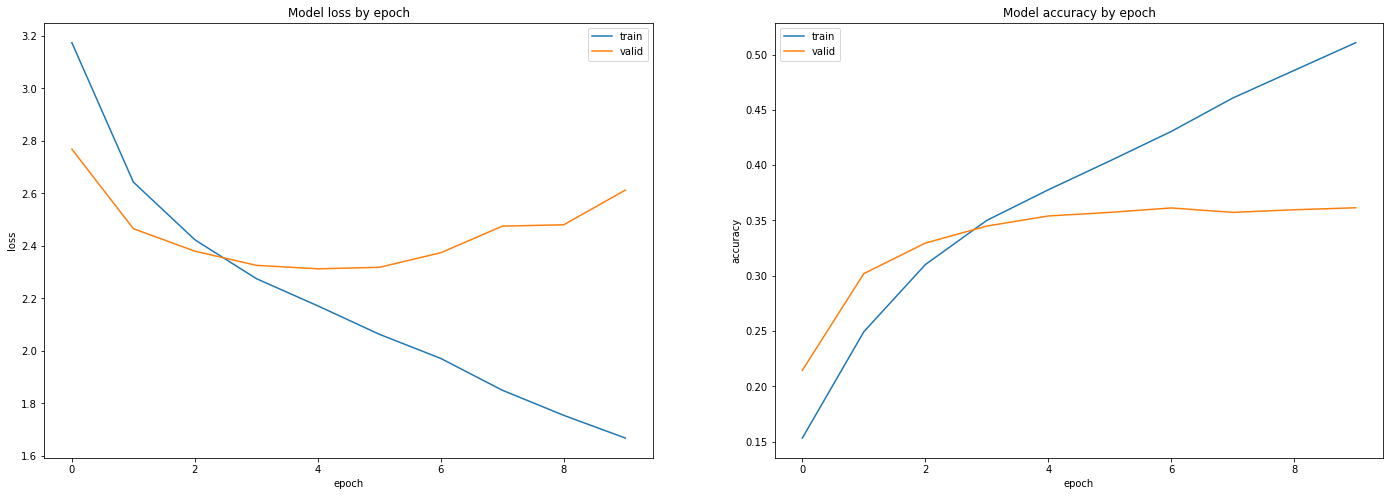

In [ ]:
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Les graphiques confirment nos observations, la fonction de perte de validation etait en train de remonter.

In [ ]:
try:
  model.load_weights(checkpoint_filepath)
except Exception:
  print(f"Checkpoint {checkpoint_filepath} not found")

In [ ]:
# We can split the full dataset, only nb_of_batch batches, because Colab does 
# not have enough RAM
def split_dataset_as_x_y(ds, input_size, nb_of_batch=100):
  ds_x = np.zeros(shape=(0,)+input_size)
  ds_y = np.array([])
  for img, label in validation_ds.take(nb_of_batch).as_numpy_iterator():
    ds_x = np.concatenate([ds_x, img], axis=0)
    ds_y = np.append(ds_y, label)
  return ds_x, ds_y

validation_x, validation_y = split_dataset_as_x_y(validation_ds, (80, 80, 3))

validation_pred = model.predict(validation_x)

validation_pred_class = pd.Series([get_label(i) for i in np.argmax(validation_pred,axis=1)])
validation_y = pd.Series([get_label(i) for i in validation_y])

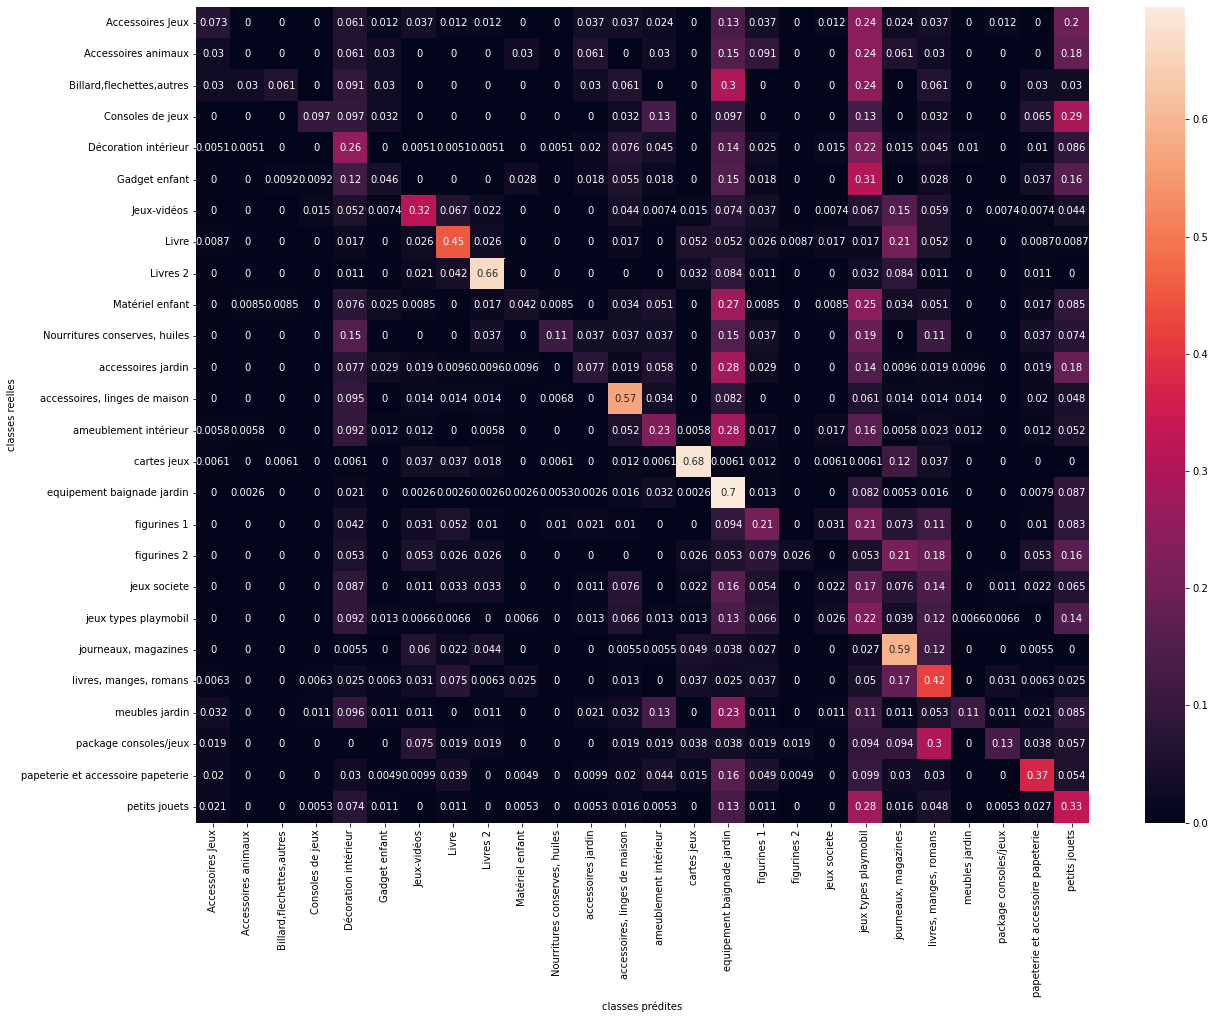

In [ ]:
plt.figure(figsize=(20, 15));
cross = pd.crosstab(validation_y, validation_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True);

In [ ]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(validation_y, validation_pred_class, output_dict=True)).transpose()
display(report.sort_values(by="f1-score", ascending=False))

,precision,recall,f1-score,support
cartes jeux,0.746667,0.682927,0.713376,164.000000
Livres 2,0.642857,0.663158,0.652850,95.000000
equipement baignade jardin,0.420128,0.695767,0.523904,378.000000
"accessoires, linges de maison",0.480000,0.571429,0.521739,147.000000
"journeaux, magazines",0.404494,0.593407,0.481069,182.000000
papeterie et accessoire papeterie,0.649573,0.374384,0.475000,203.000000
Livre,0.456140,0.452174,0.454148,115.000000
Jeux-vidéos,0.447917,0.318519,0.372294,135.000000
accuracy,0.351875,0.351875,0.351875,0.351875
"livres, manges, romans",0.282700,0.418750,0.337531,160.000000


On peut voir que les classes les mieux prédites sont:
* Cartes Jeux
* Livres 2

Puis le f1-score tombe assez rapidement. Les classes les moins bien prédites sont:
* Jeux société
* Accessoires animaux

## Entrainement de modeles complexes grace au Transfer Learning

### Modele basé sur VGG16 (Taille moyenne: VGG16 + AvgPooling + Dense 1024 + Dense 512)

On recharge nos datasets. Cette fois ci nous utilisons des générateurs pour améliorer la capacité generalisation de notre futur reseau.

Si l'on affiche les premieres images de notre dataset d'entrainement, on voit bien l'effet des generateurs qui modifient les images en leur faisant subir des transformations geométriques aléatoires.

Found 84916 files belonging to 27 classes.
Using 67933 files for training.
Found 84916 files belonging to 27 classes.
Using 16983 files for validation.


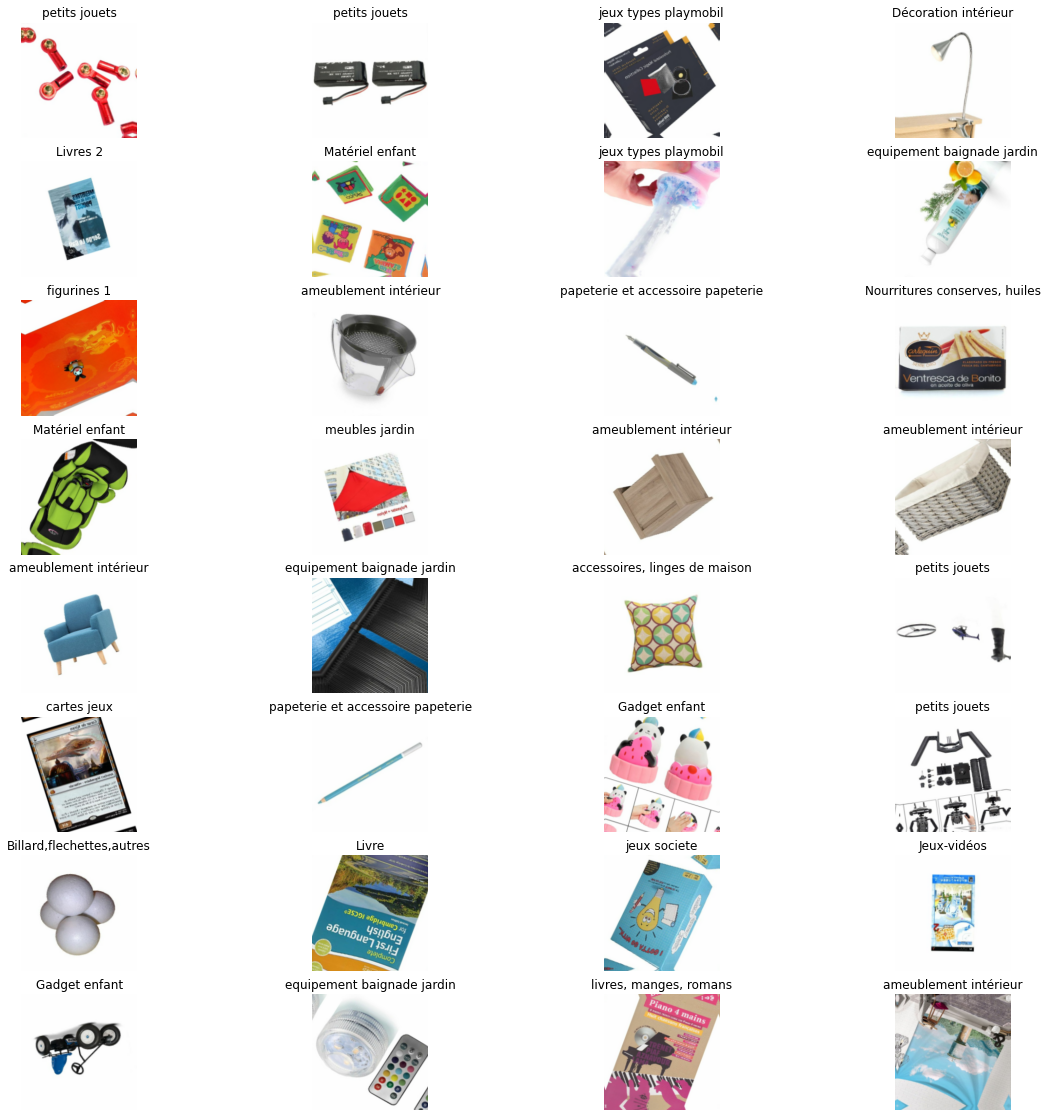

In [ ]:
BATCH_SIZE = 32
INPUT_SIZE = (224, 224)

train_ds, validation_ds = load_datasets(BATCH_SIZE, INPUT_SIZE, True)
display_first_images_from_dataset(train_ds, BATCH_SIZE)

Nous utilisons deux couches denses, précédées d'une couche d'averagepooling.
L'extracteur de feature VGG16 est initialisé avec les poids appris sur le dataset imagenet. Les layers associés sont freezés pour l'apprentissage vu qu'ils sont déja tres bons.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

nb_of_classes = len(categories)
train_size = 67933
valid_size = 16983

base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(layers.Lambda(preprocess_input, name='preprocessing', input_shape=(224, 224, 3)))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(nb_of_classes, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               

In [ ]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_vgg16_1'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds, 
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback, earlystop]
)
# La sortie et l'historique de cet entrainement ont étés perdus.

In [ ]:
try:
  model.load_weights(checkpoint_filepath)
except Exception:
  print(f"Checkpoint {checkpoint_filepath} not found")

L'accuracy de notre modele est meilleure que dans le cas du reseau de neurone entrainé de zéro.

In [ ]:
model.evaluate(validation_ds)

531/531 [==============================] - 90s 164ms/step - loss: 1.8351 - accuracy: 0.4884


[1.8351116180419922, 0.48837071657180786]

In [ ]:
validation_x, validation_y = split_dataset_as_x_y(validation_ds, INPUT_SIZE + (3,))

validation_pred = model.predict(validation_x)

validation_pred_class = pd.Series([get_label(i) for i in np.argmax(validation_pred,axis=1)])
validation_y = pd.Series([get_label(i) for i in validation_y])

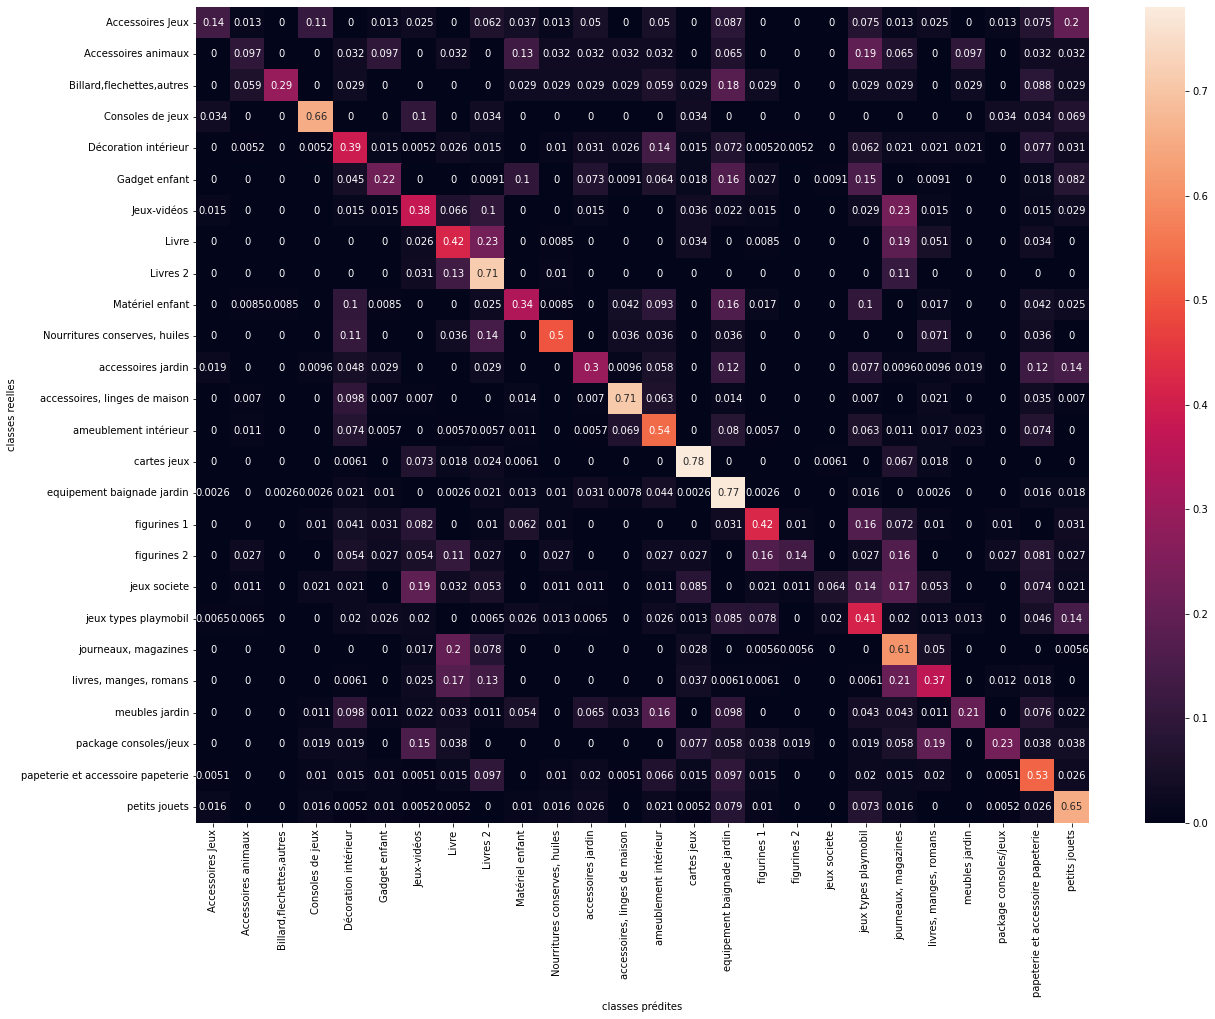

In [ ]:
plt.figure(figsize=(20, 15));
cross = pd.crosstab(validation_y, validation_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True);

In [ ]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(validation_y, validation_pred_class, output_dict=True)).transpose()
display(report.sort_values(by="f1-score", ascending=False))

,precision,recall,f1-score,support
cartes jeux,0.731429,0.780488,0.755162,164.000000
"accessoires, linges de maison",0.750000,0.713287,0.731183,143.000000
equipement baignade jardin,0.648472,0.773438,0.705463,384.000000
petits jouets,0.548246,0.654450,0.596659,191.000000
Consoles de jeux,0.463415,0.655172,0.542857,29.000000
papeterie et accessoire papeterie,0.481308,0.525510,0.502439,196.000000
accuracy,0.488438,0.488438,0.488438,0.488438
"journeaux, magazines",0.396364,0.608939,0.480176,179.000000
ameublement intérieur,0.433180,0.537143,0.479592,175.000000
weighted avg,0.500564,0.488438,0.472065,3200.000000


On peut voir que les classes les mieux prédites sont:
* Cartes Jeux
* accessoires, linges de maison
* equipement baignade jardin

Les classes les moins bien prédites sont:
* Accessoires animaux
* Jeu société

On retrouve donc plus ou moins les memes classes que avec le modele précédent.

### Modele basé sur VGG16 (Grande taille: VGG16 + Flatten + Dense 4096 + Dense 1024)

On teste de changer la couche de classification, par une couche un peu plus grande, afin de voir si cela améliore les choses.
On utilise deux layers Dense de 4096 et 1024 précédés par un layer Flatten.
Les autres parametres ne changent pas.

In [6]:
BATCH_SIZE = 32
INPUT_SIZE = (224, 224)

train_ds, validation_ds = load_datasets(BATCH_SIZE, INPUT_SIZE, True)

Found 84916 files belonging to 27 classes.
Using 67933 files for training.
Found 84916 files belonging to 27 classes.
Using 16983 files for validation.


In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

nb_of_classes = len(categories)
train_size = 67933
valid_size = 16983

base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(layers.Lambda(preprocess_input, name='preprocessing', input_shape=(224, 224, 3)))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(nb_of_classes, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                       

In [8]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_vgg16_2'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds, 
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback]
)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/20
2122/2122 [==============================] - 877s 405ms/step - loss: 1.9635 - accuracy: 0.4396 - val_loss: 1.8434 - val_accuracy: 0.4996
Epoch 2/20
2122/2122 [==============================] - 878s 413ms/step - loss: 1.9485 - accuracy: 0.4442 - val_loss: 1.8936 - val_accuracy: 0.4959
Epoch 3/20
2122/2122 [==============================] - 846s 399ms/step - loss: 1.9318 - accuracy: 0.4474 - val_loss: 1.8645 - val_accuracy: 0.5039
Epoch 4/20
2122/2122 [==============================] - 845s 398ms/step - loss: 1.9386 - accuracy: 0.4471 - val_loss: 1.8915 - val_accuracy: 0.5023
Epoch 5/20
2122/2122 [==============================] - 845s 398ms/step - loss: 1.9259 - accuracy: 0.4523 - val_loss: 1.8673 - val_accuracy: 0.5046
Epoch 6/20
2122/2122 [==============================] - 843s 397ms/step - loss: 1.9115 - accuracy: 0.4525 - val_loss: 1.8884 - val_accuracy: 0.4974
Epoch 7/20
2122/2122 [=========================

L'entrainement a été interrompu par une déconnection Colab, il semble cependant avoir suffisament convergé.

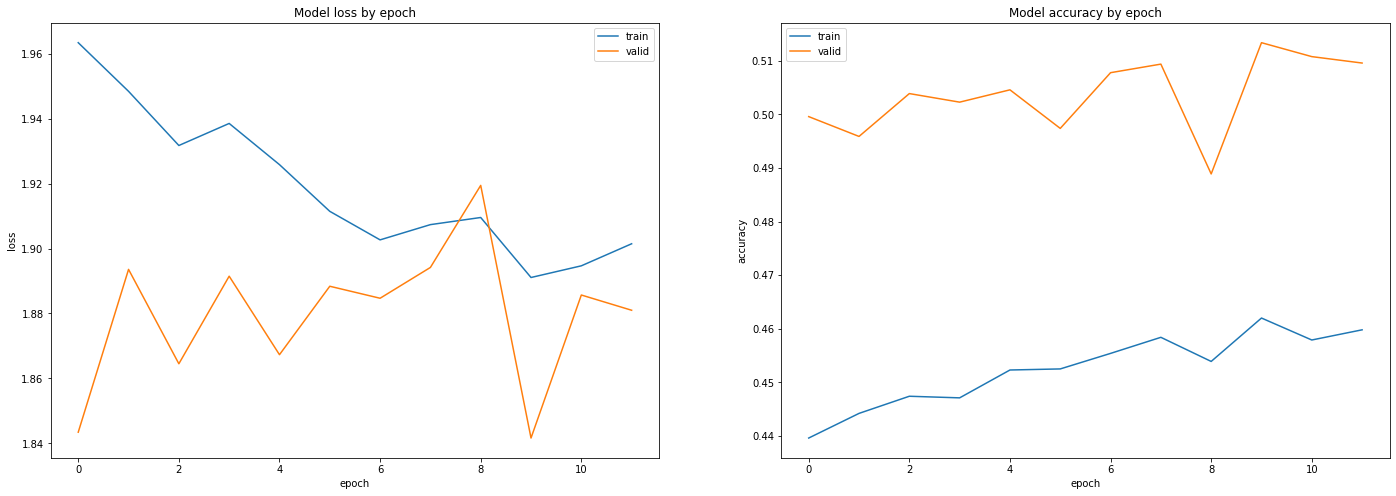

In [ ]:
history = history.history

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [10]:
try:
  model.load_weights(checkpoint_filepath)
except Exception:
  print(f"Checkpoint {checkpoint_filepath} not found")

In [11]:
model.evaluate(validation_ds)

531/531 [==============================] - 103s 162ms/step - loss: 1.8416 - accuracy: 0.5133


[1.8416416645050049, 0.5133368372917175]

On obtient une accuracy de 0.5133, ce qui constitue une amélioration par rapport au précédent modèle.

In [12]:
validation_x, validation_y = split_dataset_as_x_y(validation_ds, INPUT_SIZE + (3,))

validation_pred = model.predict(validation_x)

validation_pred_class = pd.Series([get_label(i) for i in np.argmax(validation_pred,axis=1)])
validation_y = pd.Series([get_label(i) for i in validation_y])

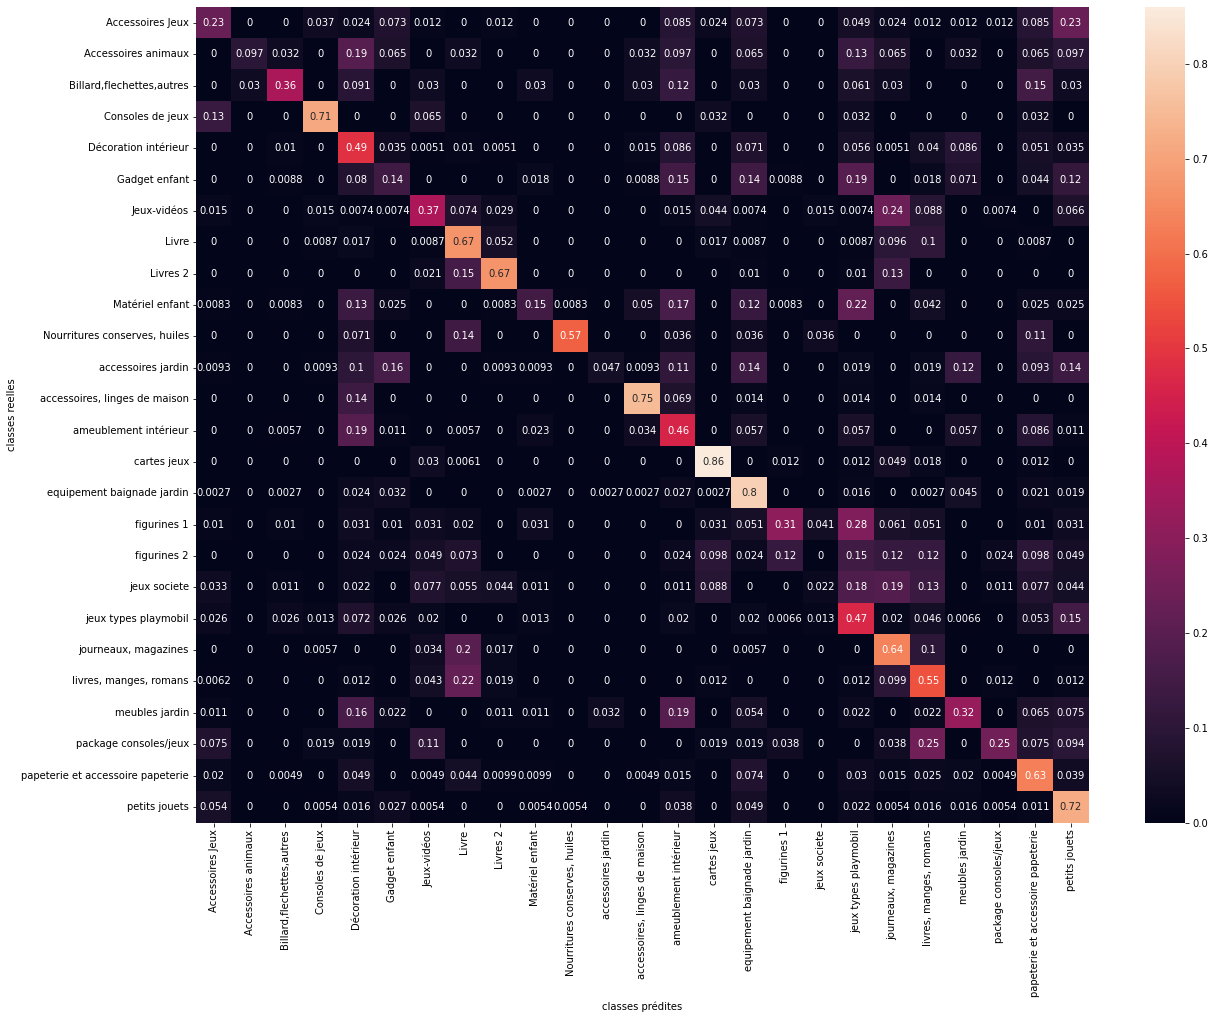

In [13]:
plt.figure(figsize=(20, 15));
cross = pd.crosstab(validation_y, validation_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True);

In [14]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(validation_y, validation_pred_class, output_dict=True)).transpose()
display(report.sort_values(by="f1-score", ascending=False))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
cartes jeux,0.824561,0.859756,0.841791,164.000000
"accessoires, linges de maison",0.837209,0.750000,0.791209,144.000000
equipement baignade jardin,0.704492,0.796791,0.747804,374.000000
"Nourritures conserves, huiles",0.888889,0.571429,0.695652,28.000000
Livres 2,0.706522,0.670103,0.687831,97.000000
Consoles de jeux,0.647059,0.709677,0.676923,31.000000
petits jouets,0.500000,0.718919,0.589800,185.000000
papeterie et accessoire papeterie,0.551724,0.630542,0.588506,203.000000
"journeaux, magazines",0.474359,0.637931,0.544118,174.000000
accuracy,0.510625,0.510625,0.510625,0.510625


On peut voir que les classes les mieux prédites sont:
* Cartes Jeux
* accessoires, linges de maison
* equipement baignade jardin

Les classes les moins bien prédites sont:
* Accessoires animaux
* Jeu société
* Figurines 2

On retrouve de nouveau les memes classes que avec le modele précédent.

### Modele basé sur VGG16 (Petite taille: VGG16 + GlobalAveragePooling + Dense 256)

On teste de changer la couche de classification, par une couche beaucoup plus petite, afin de voir si cela améliore les choses.
On utilise un layer Dense de 256 neurones précédé par un layer GlobalAveragePooling.
Les autres parametres ne changent pas.

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = (224, 224)

train_ds, validation_ds = load_datasets(BATCH_SIZE, INPUT_SIZE, True)

Found 84916 files belonging to 27 classes.
Using 67933 files for training.
Found 84916 files belonging to 27 classes.
Using 16983 files for validation.


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

nb_of_classes = len(categories)
train_size = 67933
valid_size = 16983

base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(layers.Lambda(preprocess_input, name='preprocessing', input_shape=(224, 224, 3)))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(nb_of_classes, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                6939      
                                                      

In [5]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_vgg16_3'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds, 
    epochs = 200,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/200
2122/2122 [==============================] - 797s 375ms/step - loss: 1.7702 - accuracy: 0.4795 - val_loss: 1.7579 - val_accuracy: 0.5009
Epoch 2/200
2122/2122 [==============================] - 778s 367ms/step - loss: 1.7009 - accuracy: 0.4979 - val_loss: 1.6977 - val_accuracy: 0.5119
Epoch 3/200
2122/2122 [==============================] - 778s 367ms/step - loss: 1.6621 - accuracy: 0.5061 - val_loss: 1.6869 - val_accuracy: 0.5183
Epoch 4/200
2122/2122 [==============================] - 778s 367ms/step - loss: 1.6193 - accuracy: 0.5184 - val_loss: 1.7045 - val_accuracy: 0.5231
Epoch 5/200
2122/2122 [==============================] - 778s 367ms/step - loss: 1.6023 - accuracy: 0.5227 - val_loss: 1.6531 - val_accuracy: 0.5317
Epoch 6/200
2122/2122 [==============================] - 784s 370ms/step - loss: 1.5788 - accuracy: 0.5290 - val_loss: 1.6605 - val_accuracy: 0.5278
Epoch 7/200
2122/2122 [==============================] - 778s 367ms/step - loss: 1.5673 - accuracy: 0.5328

KeyboardInterrupt: ignored

L'entrainement a été interrompu a la main car il semble avoir suffisament convergé.

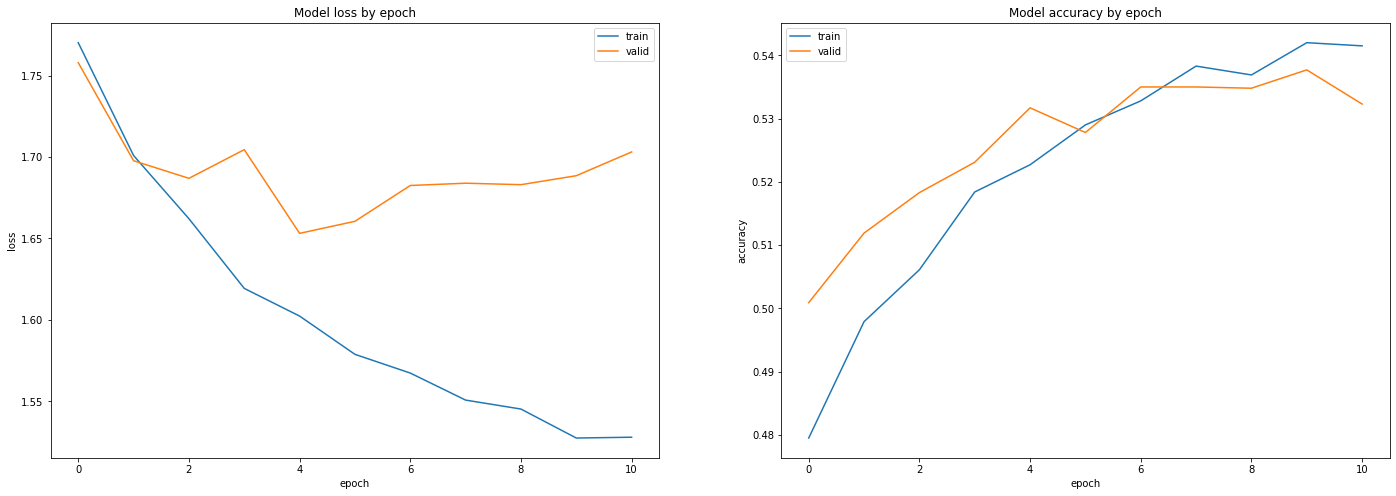

In [ ]:
history = history.history

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [6]:
try:
  model.load_weights(checkpoint_filepath)
except Exception:
  print(f"Checkpoint {checkpoint_filepath} not found")

In [19]:
model.evaluate(validation_ds)

531/531 [==============================] - 91s 169ms/step - loss: 1.6891 - accuracy: 0.5375


[1.6890612840652466, 0.5375375151634216]

On obtiens une accuracy de 0.5375, c'est notre meilleur modele jusqu'a présent.

In [9]:
validation_x, validation_y = split_dataset_as_x_y(validation_ds, INPUT_SIZE + (3,))

validation_pred = model.predict(validation_x)

validation_pred_class = pd.Series([get_label(i) for i in np.argmax(validation_pred,axis=1)])
validation_y = pd.Series([get_label(i) for i in validation_y])

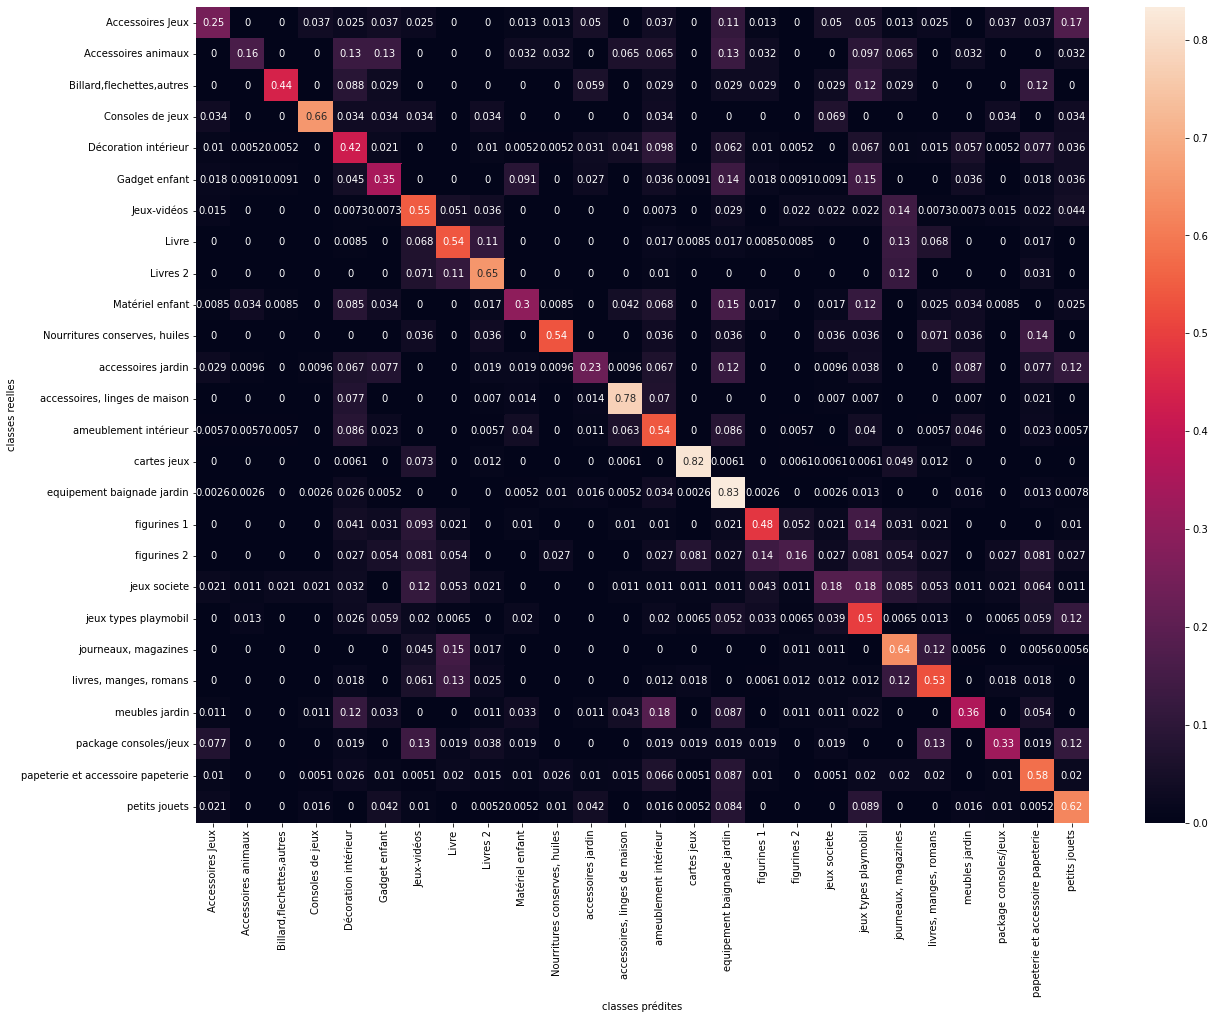

In [10]:
plt.figure(figsize=(20, 15));
cross = pd.crosstab(validation_y, validation_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True);

In [11]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(validation_y, validation_pred_class, output_dict=True)).transpose()
display(report.sort_values(by="f1-score", ascending=False))

,precision,recall,f1-score,support
cartes jeux,0.905405,0.817073,0.858974,164.000
"accessoires, linges de maison",0.740000,0.776224,0.757679,143.000
equipement baignade jardin,0.682303,0.833333,0.750293,384.000
Consoles de jeux,0.612903,0.655172,0.633333,29.000
Livres 2,0.581818,0.653061,0.615385,98.000
petits jouets,0.586207,0.623037,0.604061,191.000
"journeaux, magazines",0.537736,0.636872,0.583120,179.000
papeterie et accessoire papeterie,0.572864,0.581633,0.577215,196.000
"livres, manges, romans",0.573333,0.527607,0.549521,163.000
"Billard,flechettes,autres",0.714286,0.441176,0.545455,34.000


On peut voir que les classes les mieux prédites sont:
* Cartes Jeux
* accessoires, linges de maison
* equipement baignade jardin

Les classes les moins bien prédites sont:
* Accessoires animaux
* Jeu société
* figurines 2

Encore une fois les memes classes que précédement

### Modele basé sur Xception (Taille moyenne: Xception + GlobalAveragePooling + Dense 512 + Dense 256)

On teste de remplacer la couche d'extraction de feature, vgg16, 
On utilise un layer Dense de 256 neurones précédé par un layer GlobalAveragePooling.
Les autres parametres ne changent pas.

In [12]:
BATCH_SIZE = 32
# Les images utilisées par Xceptions sont plus petites que celles de VGG16
INPUT_SIZE = (150, 150)

train_ds, validation_ds = load_datasets(BATCH_SIZE, INPUT_SIZE, True)

Found 84916 files belonging to 27 classes.
Using 67933 files for training.
Found 84916 files belonging to 27 classes.
Using 16983 files for validation.


In [13]:
from tensorflow.keras.applications import Xception

nb_of_classes = len(categories)
train_size = 67933
valid_size = 16983

base_model = Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)  
base_model.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))
# Pour le preprocessing on rescale les valeurs des pixels de [0,255] a [-1,1]
# car c'est ce qui est attendu par Xception
scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(nb_of_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0      

In [14]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_xception_1'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds, 
    epochs = 40,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/40
2122/2122 [==============================] - 493s 225ms/step - loss: 2.0773 - accuracy: 0.3956 - val_loss: 1.9059 - val_accuracy: 0.4384
Epoch 2/40
2122/2122 [==============================] - 450s 212ms/step - loss: 1.8766 - accuracy: 0.4491 - val_loss: 1.8529 - val_accuracy: 0.4524
Epoch 3/40
2122/2122 [==============================] - 436s 205ms/step - loss: 1.8119 - accuracy: 0.4656 - val_loss: 1.8334 - val_accuracy: 0.4601
Epoch 4/40
2122/2122 [==============================] - 435s 205ms/step - loss: 1.7623 - accuracy: 0.4776 - val_loss: 1.7869 - val_accuracy: 0.4739
Epoch 5/40
2122/2122 [==============================] - 443s 209ms/step - loss: 1.7303 - accuracy: 0.4859 - val_loss: 1.7820 - val_accuracy: 0.4783
Epoch 6/40
2122/2122 [==============================] - 434s 205ms/step - loss: 1.7005 - accuracy: 0.4943 - val_loss: 1.7498 - val_accuracy: 0.4891
Epoch 7/40
2122/2122 [==============================] - 437s 206ms/step - loss: 1.6785 - accuracy: 0.5016 - val_

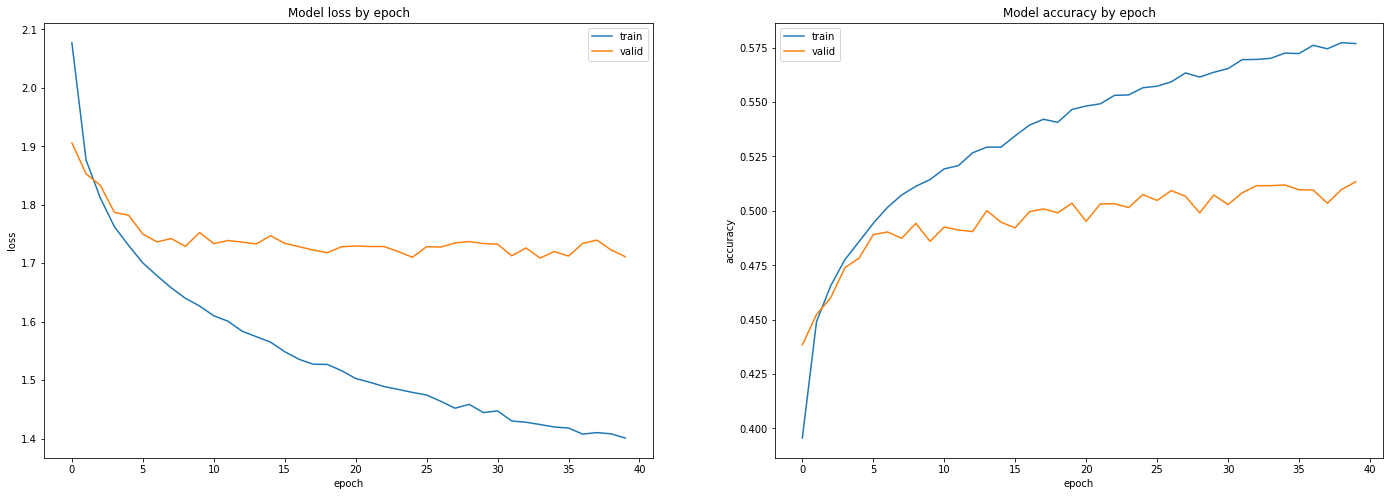

In [ ]:
history = {
    'loss': [2.0773, 1.8766, 1.8119, 1.7623, 1.7303, 1.7005, 1.6785, 1.6579, 1.6399, 1.6267, 1.6100, 1.6007, 1.5836, 1.5742, 1.5649, 1.5486, 1.5356, 1.5271, 1.5268, 1.5162, 1.5027, 1.4962, 1.4889, 1.4840, 1.4789, 1.4744, 1.4637, 1.4518, 1.4584, 1.4444, 1.4472, 1.4300, 1.4278, 1.4239, 1.4197, 1.4179, 1.4075, 1.4101, 1.4080, 1.4008],
    'val_loss': [1.9059, 1.8529, 1.8334, 1.7869, 1.7820, 1.7498, 1.7364, 1.7421, 1.7287, 1.7526, 1.7334, 1.7388, 1.7360, 1.7329, 1.7470, 1.7340, 1.7283, 1.7225, 1.7179, 1.7281, 1.7294, 1.7285, 1.7285, 1.7199, 1.7101, 1.7283, 1.7276, 1.7346, 1.7370, 1.7336, 1.7326, 1.7126, 1.7260, 1.7088, 1.7199, 1.7122, 1.7338, 1.7395, 1.7227, 1.7111],
    'accuracy': [0.3956, 0.4491, 0.4656, 0.4776, 0.4859, 0.4943, 0.5016, 0.5073, 0.5113, 0.5144, 0.5193, 0.5208, 0.5267, 0.5293, 0.5293, 0.5345, 0.5394, 0.5421, 0.5407, 0.5466, 0.5482, 0.5492, 0.5531, 0.5533, 0.5566, 0.5573, 0.5593, 0.5634, 0.5615, 0.5637, 0.5654, 0.5695, 0.5696, 0.5701, 0.5725, 0.5723, 0.5761, 0.5745, 0.5773, 0.5769],
    'val_accuracy': [0.4384, 0.4524, 0.4601, 0.4739, 0.4783, 0.4891, 0.4903, 0.4874, 0.4943, 0.4860, 0.4926, 0.4912, 0.4905, 0.5001, 0.4948, 0.4922, 0.4996, 0.5009, 0.4991, 0.5035, 0.4952, 0.5032, 0.5033, 0.5015, 0.5075, 0.5048, 0.5093, 0.5067, 0.4991, 0.5073, 0.5029, 0.5083, 0.5116, 0.5116, 0.5119, 0.5097, 0.5096, 0.5035, 0.5098, 0.5134]
}

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [15]:
try:
  model.load_weights(checkpoint_filepath)
except Exception:
  print(f"Checkpoint {checkpoint_filepath} not found")

In [16]:
model.evaluate(validation_ds)

531/531 [==============================] - 192s 348ms/step - loss: 1.7107 - accuracy: 0.5136


[1.7106977701187134, 0.5135723948478699]

In [17]:
# We can't split the full dataset, only nb_of_batch batches, because Colab does 
# not have enough RAM
def split_dataset_as_x_y(ds, input_size, nb_of_batch=100):
  ds_x = np.zeros(shape=(0,)+input_size)
  ds_y = np.array([])
  for img, label in validation_ds.take(nb_of_batch).as_numpy_iterator():
    ds_x = np.concatenate([ds_x, img], axis=0)
    ds_y = np.append(ds_y, label)
  return ds_x, ds_y

validation_x, validation_y = split_dataset_as_x_y(validation_ds, INPUT_SIZE + (3,))

validation_pred = model.predict(validation_x)

validation_pred_class = pd.Series([get_label(i) for i in np.argmax(validation_pred,axis=1)])
validation_y = pd.Series([get_label(i) for i in validation_y])

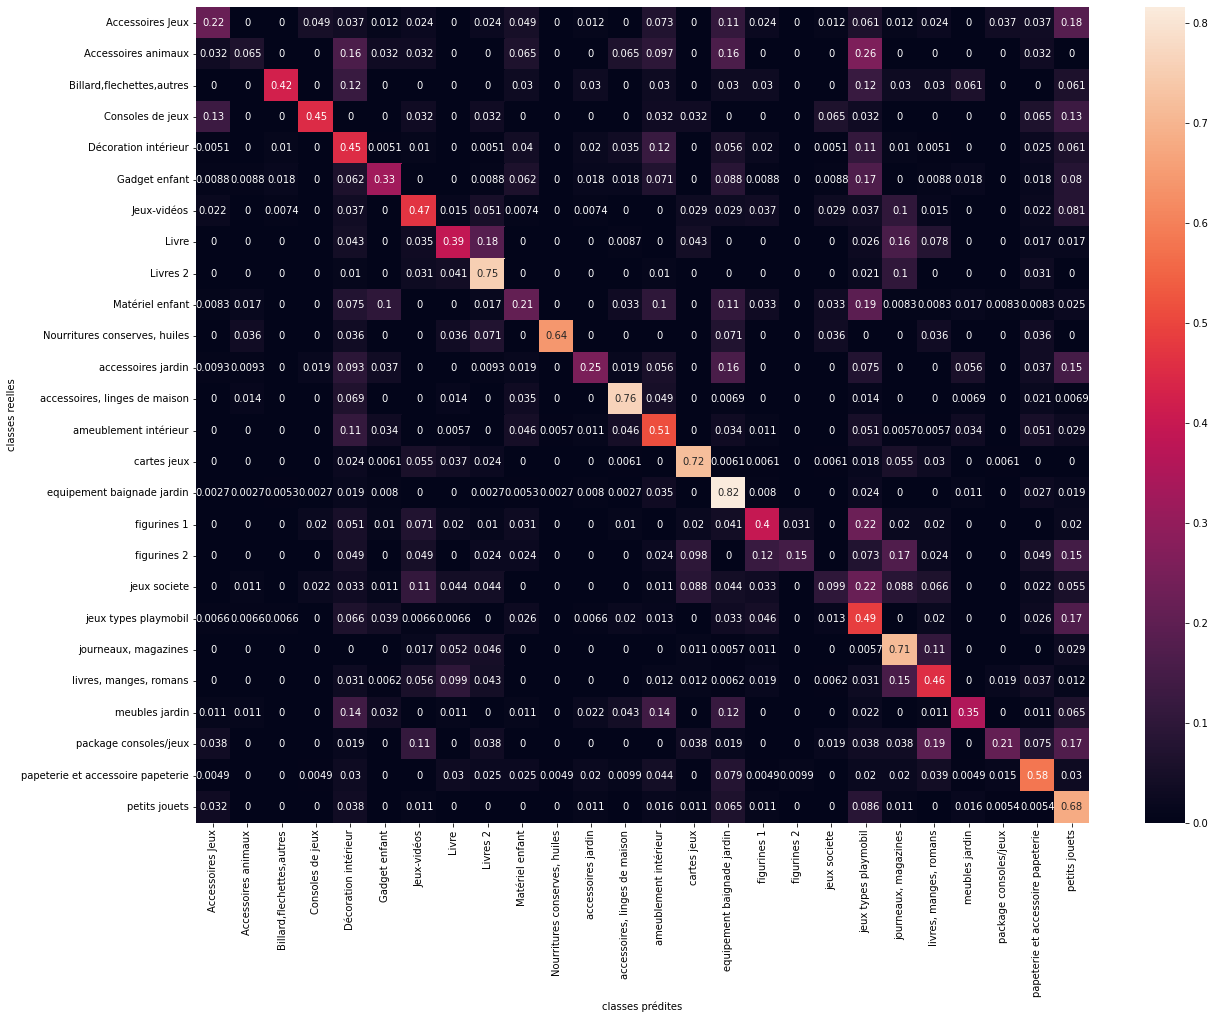

In [18]:
plt.figure(figsize=(20, 15));
cross = pd.crosstab(validation_y, validation_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True);

In [19]:
from sklearn.metrics import classification_report
report = pd.DataFrame(classification_report(validation_y, validation_pred_class, output_dict=True)).transpose()
display(report.sort_values(by="f1-score", ascending=False))

,precision,recall,f1-score,support
"accessoires, linges de maison",0.743243,0.763889,0.753425,144.00
cartes jeux,0.786667,0.719512,0.751592,164.00
equipement baignade jardin,0.693182,0.815508,0.749386,374.00
"Nourritures conserves, huiles",0.857143,0.642857,0.734694,28.00
"journeaux, magazines",0.536797,0.712644,0.612346,174.00
Livres 2,0.506944,0.752577,0.605809,97.00
papeterie et accessoire papeterie,0.631016,0.581281,0.605128,203.00
petits jouets,0.450000,0.681081,0.541935,185.00
accuracy,0.520000,0.520000,0.520000,0.52
"Billard,flechettes,autres",0.636364,0.424242,0.509091,33.00


On peut voir que les classes les mieux prédites sont:
* Cartes Jeux
* accessoires, linges de maison
* equipement baignade jardin

Les classes les moins bien prédites sont:
* Accessoires animaux
* Jeu société

## Comparaison finale des modeles

Nous avons compilés a postériori les classifications reports des différents modèles dans un csv, afin de les comparer.

On regarde quel modele a globalement le meilleur f1-score toutes catégories confondues. Il s'agit bien du petit modele basé sur VGG16. C'est aussi celui qui a la meilleure accuracy. 

In [20]:
reports = pd.read_csv("drive/MyDrive/reports.csv", index_col=0)

In [21]:
import numpy as np

f1_score = reports[["f1-score_xception", "f1-score_vgg_small", "f1-score_vgg_big", "f1-score_vgg_med", "f1-score_simple"]]

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

f1_score.style.apply(highlight_max, props='color:white;background-color:green;', axis=1)

,f1-score_xception,f1-score_vgg_small,f1-score_vgg_big,f1-score_vgg_med,f1-score_simple
name,,,,,
"accessoires, linges de maison",0.753425,0.757679,0.791209,0.731183,0.521739
cartes jeux,0.751592,0.858974,0.841791,0.755162,0.713376
equipement baignade jardin,0.749386,0.750293,0.747804,0.705463,0.523904
"Nourritures conserves, huiles",0.734694,0.500000,0.695652,0.437500,0.162162
"journeaux, magazines",0.612346,0.583120,0.544118,0.480176,0.481069
Livres 2,0.605809,0.615385,0.687831,0.457516,0.652850
papeterie et accessoire papeterie,0.605128,0.577215,0.588506,0.502439,0.475000
petits jouets,0.541935,0.604061,0.589800,0.596659,0.263270
"Billard,flechettes,autres",0.509091,0.545455,0.406780,0.434783,0.105263
